In [4]:
import math, random, os

import sys
sys.path.append('..')


import numpy as np
import pandas as pd
from collections import defaultdict

import os
import torch
import torch.nn as nn
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [5]:
######################################## load data from junyi log
bath_path = '/mnt/qb/work/mlcolab/hzhou52/kt/junyi/'

# exercise 837, topic 41, area 9
# exercise = pd.read_csv(bath_path+'junyi_Exercise_table.csv', encoding = "utf-8",low_memory=False) 
# relation = pd.read_csv(bath_path+'relationship_annotation_training.csv', encoding = "utf-8",low_memory=False)
log = pd.read_csv(bath_path+'junyi_ProblemLog_original.csv', encoding = "utf-8",low_memory=False)

users = log.groupby(['user_id', 'exercise']).size().reset_index(name='count')
users[users['count']>100]
# users = users.sort_values('count')

,user_id,exercise,count
98,16,adding_and_subtracting_negative_numbers,118
387,52,alternate_exterior_angles,119
388,52,alternate_interior_angles,101
492,52,metric_weight_unit_conversion,136
654,64,reading_fractions_in_chinese,148
...,...,...,...
2288785,247492,multiplication_0.5,741
2288786,247492,multiplication_1,266
2288888,247507,subtraction_1,113
2289046,247529,addition_1,119


In [3]:
################### find specific data
user201 = log.loc[(log.user_id == 247569) & (log.exercise == 'divisibility_0.5')]
user118 = log.loc[(log.user_id == 16) & (log.exercise == 'adding_and_subtracting_negative_numbers')]
user384 = log.loc[(log.user_id == 945) & (log.exercise == 'number_line_3')]

user118 = user118.sort_values('time_done')
user201 = user201.sort_values('time_done')
user384 = user384.sort_values('time_done')

# first = log.loc[(log.user_id == 88703) & (log.exercise == 'telling_time_comparing')]
# second = log.loc[(log.user_id == 88703) & (log.exercise == 'time_units_transformation_1')]
# third = log.loc[(log.user_id == 52504) & (log.exercise == 'radical_equations')]
# first = first.sort_values('time_done')

user118.to_csv('user118.csv', sep='\t')
user201.to_csv('user201.csv', sep='\t')
user384.to_csv('user384.csv', sep='\t')

In [ ]:
######################################## load data from pre-defined user-specific log
user118 = pd.read_csv('user118.csv', sep='\t')

num_seq = 1
num_node = 1

t_data = torch.tensor(np.array(user118['time_done'].values), device=device).reshape(1, -1)
x_data = torch.tensor(np.array(user118['correct'].values*1), device=device).reshape(1, -1)

In [ ]:
################### rescale time data
log_t_data = [] # so that the log(diff(t_data)) = diff(log_t_data)
dt = torch.log(torch.diff(t_data))
log_t_data.append(torch.zeros_like(dt[:,0]))
for i in range(0, dt.shape[-1]):
    log_t_data.append(log_t_data[-1] + dt[:, i])
log_t_data = torch.stack(log_t_data, -1)

In [ ]:
######################################## single_user_single_exercise
# TODO it is extermely slow now
useful_log = log[['user_id', 'exercise', 'time_done', 'correct']]
max_num = 200
interaction = pd.DataFrame(['user_id', 'skill', 'time_seq', 'correct_seq'])

users[users['count']>max_num]
users_with_threshold = users[users['count']>max_num]

single_user_single_exercise = dict({
    'user_id': [],
    'skill': [],
    'time_seq': [],
    'correct_seq': [],
})

sk_dfs = []
for i in range(len(users_with_threshold)):
    if i % 50==0:
        print(i)
    id = users_with_threshold.user_id.iloc[i]
    ex = users_with_threshold.exercise.iloc[i]

    single_user_exercise = useful_log.loc[(useful_log.user_id == id) & (useful_log.exercise == ex)]
    single_user_exercise = single_user_exercise.sort_values('time_done')[:max_num]

    sk_dfs.append(single_user_exercise)
    
# single_user_single_exercise = pd.DataFrame.from_dict(single_user_single_exercise)
# single_user_single_exercise.to_csv('single_user_single_exercise_junyi_200.csv')

In [ ]:
######################################## exercise-id re-match
# same as preprocessing
exercise = pd.read_csv(bath_path+'junyi_Exercise_table.csv', encoding = "utf-8",low_memory=False) 
num_ex = len(exercise)

ex_new_id = pd.DataFrame(columns=['exercise_name', 'exercise_id', 'prerequisite_name', 'prerequisite_id'])
ex_new_id['exercise_name'] = exercise.name
ex_new_id['exercise_id'] = np.arange(len(exercise))
ex_new_id['prerequisite_name'] = exercise.prerequisites

for i in range(len(ex_new_id.prerequisite_name)):
    pre = ex_new_id['prerequisite_name'][i]
    ind = exercise.loc[exercise.name == pre].index
    if len(ind) == 0:
        ex_new_id.prerequisite_id[i] = np.nan
    else:
        ex_new_id.prerequisite_id[i] = ind[0]

In [72]:
import pickle
pickle.dump(sk_dfs, open('sk_dfs.pkl', 'wb'))

In [64]:
test = sk_dfs
test = pd.concat(test, axis=0)
test.columns = ['original_user_id', 'skill_name', 'timestamp', 'correct']

new_id = [[i] * max_num for i in range(len(sk_dfs))]
new_user_id = [item for sublist in new_id for item in sublist]
test['user_id'] = new_user_id

skill_dict = dict(zip(ex_new_id.exercise_name, ex_new_id.exercise_id))
test['skill_id'] = test['skill_name'].apply(lambda x: skill_dict[x])

test['problem_id'] = test.skill_id

test = test.astype({
    'timestamp': np.float64,
    # 'dwell_time': np.float64,
    'correct': np.float64,
    'problem_id': np.int64,
    'skill_id': np.int64,
    'user_id': np.int64,
    })

# Save
bath_path = '/mnt/qb/work/mlcolab/hzhou52/kt/junyi/single_user_single_skill/'
test.to_csv(bath_path+'interactions_{}.csv'.format(max_num), sep='\t', index=False)

In [148]:
######################################## add statistics
num_seq = 1
num_node = 1
def add_statistics(x_data, time_step):
    num_total = np.arange(time_step) # how many times in total has the learner tried
    success = 0
    num_success = []
    for i in range(time_step):
        if x_data[i] == 1:
            success += 1
        num_success.append(success)
    num_failure = num_total-num_success

    stats = np.stack([num_total, num_success, num_failure], -1).reshape(num_seq, num_node, -1, 3)
    # stats = torch.tensor(stats, device=device)
    return stats

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import default_collate

class CustomImageDataset(Dataset):
    def __init__(self, single_user_single_exercise, device):
        self.pd_data = single_user_single_exercise
        self.device = device
        
    def __len__(self):
        return len(self.pd_data)
    
    def __getitem__(self, idx):
        user_id = self.pd_data.user_id.iloc[idx]
        time_seq = [int(s) for s in self.pd_data.time_seq.iloc[idx][1:-1].split(',')] 
        time_seq = np.array(time_seq)
        correct_seq = [int(s) for s in self.pd_data.correct_seq.iloc[idx][1:-1].split(',')] 
        correct_seq = np.array(correct_seq)
        stats = add_statistics(correct_seq, len(correct_seq))[0]
        return user_id, time_seq, correct_seq, stats

In [149]:
dataset = CustomImageDataset(single_user_single_exercise, device)
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler,
                                          collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler,
                                            collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [160]:
model = HLR(mode='train', device=device)
num_epochs = 10
learning_rate = 1e-3 
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # Train:   
    for _, (user_id, time_seq, correct_seq, stats) in enumerate(train_loader):
        # user_id [bs]
        # time_seq [bs, max_time]
        # correct_seq [bs, max_time]
        # stats [bs, 1, 1, max_time, 3]
        x0 = correct_seq[:, :1]
        x_gt = correct_seq[:, 1:]
        x_pred, params = model.simulate_path(x0=x0, t=time_seq, stats=stats)
        p = params['x_item_pred']
        h = params['half_life']
        bceloss = loss_fn(p, x_gt.float())

        optimizer.zero_grad()
        bceloss.backward()
        optimizer.step()
    
        print('x_pred: ', x_pred)
        print('loss: ', bceloss)
        print('previous theta: ', model.theta.clone())

x_pred:  tensor([[[1.0000, 0.5000, 0.5000,  ..., 0.7165, 0.7167, 0.7130]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.7179, 0.7141, 0.7176]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        ...,

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.7050, 0.6996, 0.7064]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]],
       device='cuda:0', grad_fn=<StackBackward0>)
loss:  tensor(0.6183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
previous theta:  tensor([-1.0296,  1.1021, -0.8681], device='cuda:0', grad_fn=<CloneBackward0>)
x_pred:  tensor([[[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        ...,

        [[1.0000, 0.5000, 0.5026,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.50

x_pred:  tensor([[[0.0000, 0.5000, 0.5000,  ..., 0.7067, 0.6732, 0.5749]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5178, 0.5136]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.7184, 0.7007, 0.6725]],

        ...,

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5011, 0.5016,  ..., 0.7180, 0.7171, 0.7167]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.7073, 0.7077, 0.7053]]],
       device='cuda:0', grad_fn=<StackBackward0>)
loss:  tensor(0.6268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
previous theta:  tensor([-1.0131,  1.1183, -0.8678], device='cuda:0', grad_fn=<CloneBackward0>)
x_pred:  tensor([[[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.7065, 0.7118, 0.7154]],

        ...,

        [[1.0000, 0.5002, 0.5038,  ..., 0.7198, 0.7195, 0.7190]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.7157, 0.7194, 0.71

x_pred:  tensor([[[1.0000, 0.5000, 0.5004,  ..., 0.6801, 0.7212, 0.7201]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5576, 0.5351, 0.6269]],

        ...,

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5023, 0.5000,  ..., 0.6784, 0.7105, 0.7078]],

        [[1.0000, 0.5000, 0.5005,  ..., 0.7192, 0.7170, 0.7177]]],
       device='cuda:0', grad_fn=<StackBackward0>)
loss:  tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
previous theta:  tensor([-1.0020,  1.1291, -0.8675], device='cuda:0', grad_fn=<CloneBackward0>)
x_pred:  tensor([[[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.6946, 0.6863, 0.6961]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        ...,

        [[1.0000, 0.5000, 0.5000,  ..., 0.7159, 0.7189, 0.7071]],

        [[1.0000, 0.5004, 0.5020,  ..., 0.7191, 0.7198, 0.71

x_pred:  tensor([[[1.0000, 0.5004, 0.5008,  ..., 0.7053, 0.7131, 0.7148]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5145, 0.5001, 0.5607]],

        ...,

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]],
       device='cuda:0', grad_fn=<StackBackward0>)
loss:  tensor(0.5798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
previous theta:  tensor([-0.9938,  1.1371, -0.8673], device='cuda:0', grad_fn=<CloneBackward0>)
x_pred:  tensor([[[0.0000, 0.5000, 0.5000,  ..., 0.7062, 0.7070, 0.6945]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.7170, 0.6568, 0.7186]],

        [[1.0000, 0.5000, 0.5010,  ..., 0.7177, 0.7177, 0.7163]],

        ...,

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.7073, 0.7054, 0.70

KeyboardInterrupt: 

In [212]:
# from ou_estimator import OrnsteinUhlenbeckEstimator
log_t_data = [] # so that the log(diff(t_data)) = diff(log_t_data)
dt = torch.log(torch.diff(t_data))
log_t_data.append(torch.zeros_like(dt[:,0]))
for i in range(0, dt.shape[-1]):
    log_t_data.append(log_t_data[-1] + dt[:, i])
log_t_data = torch.stack(log_t_data, -1)

numpy_data = [(time_seq.cpu().numpy(), correct_seq.cpu().numpy()) for _, (_, time_seq, correct_seq, _) in enumerate(train_loader)]
estimator = OrnsteinUhlenbeckEstimator(numpy_data, n_it=10)

In [213]:
print(f'mu = {estimator.mu}')
print(f'eta = {estimator.eta}')
print(f'sigma^2 = {estimator.sigma_sq()}')

mu = 0.8482042530182574
eta = 1.0496364139222869e-06
sigma^2 = 7.670892715022106e-10


<Figure size 640x480 with 0 Axes>

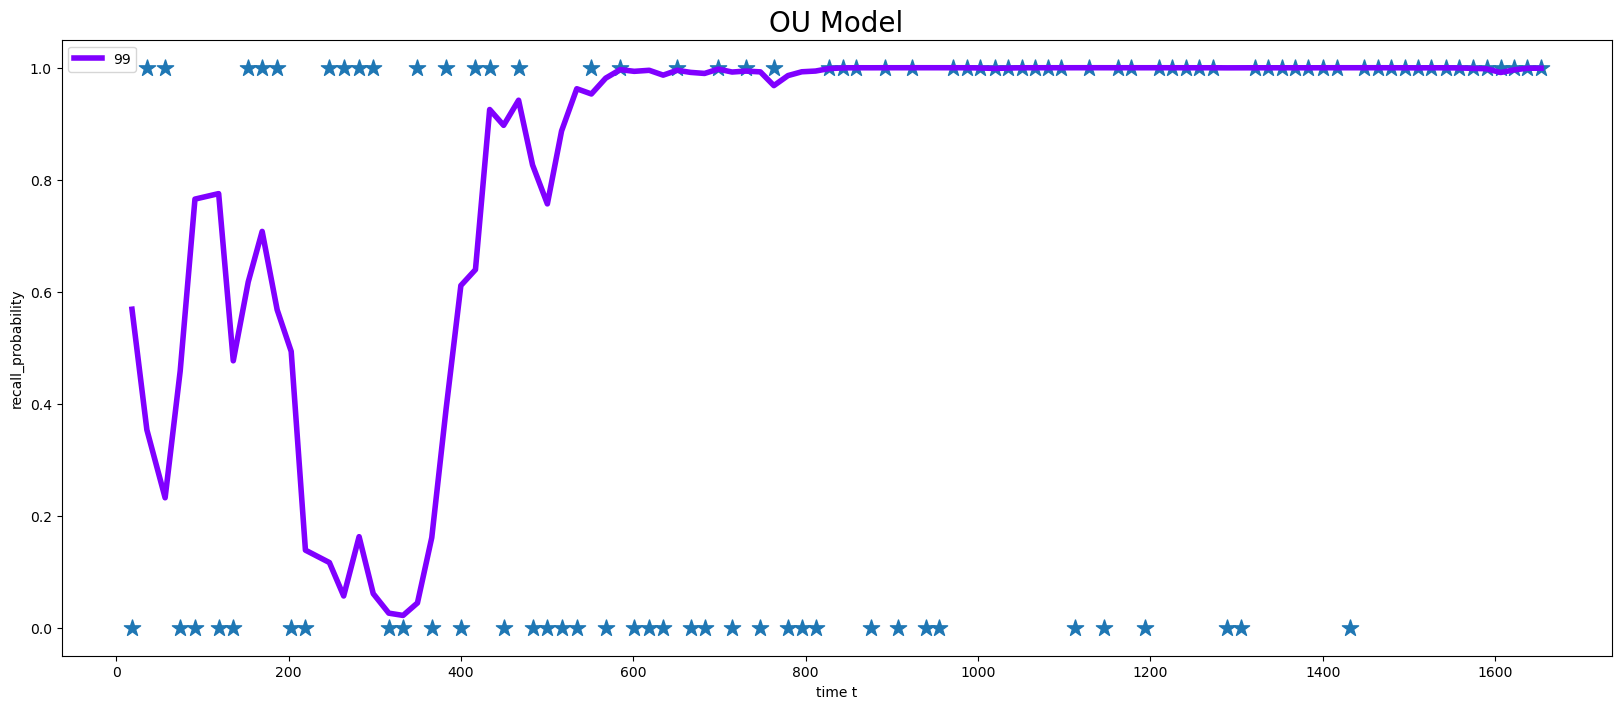

In [164]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import networkx as nx
import os
import imageio
import ipdb



path = x[0,:,0,0].numpy()
times=time[0].numpy()

plt.clf()

color = cm.rainbow(np.linspace(0, 1, num_node))
plt.figure(figsize=(20,8))
plt.xlabel('time t')
plt.ylabel('recall_probability')
plt.title(label='OU Model',
        fontsize=20,
        color="black")

plt.plot(scale, sigmoid(path), color=c, label='{}'.format(i), linewidth=4)

plt.scatter(scale, x_data[1:], s=150, marker='*')
    # plt.vlines(x=times[ind], ymin = np.min(path), ymax = np.max(path),
            # colors = 'grey', linestyles='dashdot')# ,
            # label = 'vline_multiple - full height')


plt.legend()

# Duolingo Data

In [76]:
bath_path = '/mnt/qb/work/mlcolab/hzhou52/kt/Duolingo/learning_traces.csv'
log = pd.read_csv(bath_path, encoding = "utf-8",low_memory=False)

In [77]:
log.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1
4,1.0,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1


In [78]:
users = log.groupby(['user_id', 'lexeme_id']).size().reset_index(name='count')
users.sort_values('count')

,user_id,lexeme_id,count
0,u:--N,01a14ea3963721a9d545dce1acc30f2f,1
3544992,u:hqtH,eb94d71d2ab1d501b230eee9d287fe73,1
3544993,u:hqtH,ec2421cd46a8a5886683b084aa8e2c5d,1
3544994,u:hqtH,ede6ab035e42c5f5523c73f955f036ac,1
3544995,u:hqtH,eee8e3c0843d6ace41d204202f197909,1
...,...,...,...
269756,u:bcH_,97e922f780d628eac638bea7a02bf496,278
269685,u:bcH_,827a8ecb89f9b59ac5c29b620a5d3ed6,295
269409,u:bcH_,33a7fd42f74b2d2b1110f1b0c8b6db38,316
269600,u:bcH_,6d4c572af8022cb4784ce0f8898d1905,328


In [79]:
log.loc[log.user_id == 'u:bcH_']

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
193803,0.0,1362092353,61015,u:bcH_,en,es,55f383178cf0fdc463ef1ebf91bd288d,milk/milk<n><sg>,157,116,1,0
193804,1.0,1362092353,83142,u:bcH_,en,es,a5acd980d17d726d1c99e7b974d3f52d,for/for<pr>,750,481,1,1
193805,0.0,1362092353,83951,u:bcH_,en,es,9eedd98a29691237d18c127468452836,music/music<n><sg>,181,110,1,0
193806,0.0,1362092353,61191,u:bcH_,en,es,4adf5cd40d521b02a9cc241bf3adc6bb,have/have<vblex><inf>,913,583,1,0
193807,0.0,1362092353,83951,u:bcH_,en,es,b830ca5fa936b0cff94fe712d6847f29,listen/listen<vblex><pres>,93,58,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12504242,1.0,1363066201,2678082,u:bcH_,en,es,6e7589c6b19e910e6f24f8313ab231b9,these/this<prn><tn><mf><pl>,43,33,1,1
12504243,1.0,1363066201,144,u:bcH_,en,es,32d10b7ed0bea958c60a915710434dfe,can/can<vaux><pres>,1166,899,1,1
12504244,0.0,1363066201,454,u:bcH_,en,es,46a16bfbe06339264594d523fb04bf7a,restaurant/restaurant<n><sg>,470,241,1,0
12504245,0.5,1363066201,144,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,5589,3230,2,1
